In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/IDC_AdvML

/content/gdrive/.shortcut-targets-by-id/1Fg_Qoe86_zPHEpJP7qQTjfY7jrnT010g/IDC_AdvML


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
#Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

#ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('train_data_for_students.tsv', sep='\t|\n',names=['id', 'user', 'tweet', 'date', 'device'], engine='python')
df['date']=df['date'].astype("datetime64")

In [ ]:
df.head(5)

,id,user,tweet,date,device
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android


# Performing some EDA on the tweets data

In [ ]:
df.isna().sum()

id        0
user      0
tweet     0
date      0
device    0
dtype: int64

In [ ]:
df.user.value_counts(dropna=False)

realDonaldTrump    2987
PressSec             12
POTUS                 1
Name: user, dtype: int64

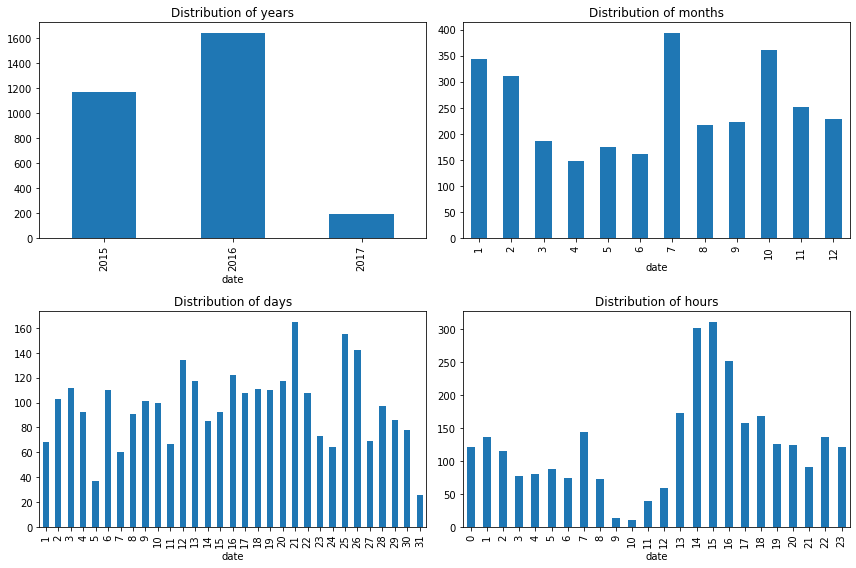

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
df.groupby(df["date"].dt.year)['id'].count().plot(kind="bar",ax=ax[0][0],title='Distribution of years')
df.groupby(df["date"].dt.month)['id'].count().plot(kind="bar",ax=ax[0][1],title='Distribution of months')
df.groupby(df["date"].dt.day)['id'].count().plot(kind="bar",ax=ax[1][0],title='Distribution of days')
df.groupby(df["date"].dt.hour)['id'].count().plot(kind="bar",ax=ax[1][1],title='Distribution of hours')
fig.tight_layout()
plt.show()

In [ ]:
df.device.value_counts(dropna=False)

android                                                                                1925
iphone                                                                                  831
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      210
<a href="http://www.twitter.com" rel="nofollow">Twitter for BlackBerry</a>               13
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
<a href="http://instagram.com" rel="nofollow">Instagram</a>                               4
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>         4
<a href="https://periscope.tv" rel="nofollow">Periscope.TV</a>                            3
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                     1
Name: device, dtype: int64

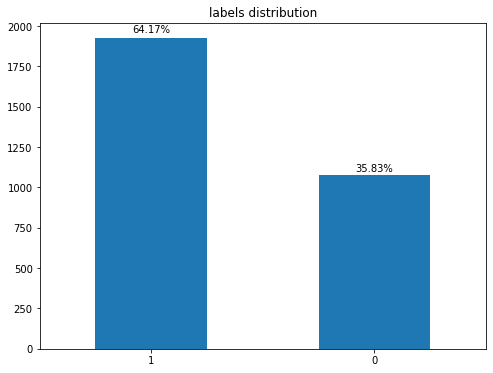

In [ ]:
# labels distribution
ax = df['device'].apply(lambda x: 1 if x == 'android' else 0).value_counts(dropna=False).plot(kind='bar',figsize=(8, 6),title='labels distribution')
a = len(df['device'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{(height/a)*100:.2f}%', (x + width/2, y + height*1.02), ha='center')
plt.xticks(rotation=0)
plt.show()

# Feature engineering

Adding sentiment analysis feature on tweets

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


lets drop users which are not trump

In [ ]:
df = df[df['user'] == 'realDonaldTrump']

In [ ]:
def clean_tweets(text):
  text = text.replace('&amp;', 'and')
  text = re.sub("RT @[\w]*:","",text)
  text = re.sub("@[\w]*","",text)
  text = re.sub("https?://[A-Za-z0-9./]*","",text)
  text = re.sub("\n","",text)
  return text

In [ ]:
def feature_eng(df):
    df['tweet'] = df['tweet'].str.replace('&amp;', 'and') #Lets take care of special characters
    df['hashtag'] = df['tweet'].apply(lambda x: 1 if '#' in x else 0)
    df['tag'] = df['tweet'].apply(lambda x: 1 if '@' in x else 0) 
    df['hashlen'] = df['tweet'].str.count('#')
    df['taglen'] = df['tweet'].str.count('@')
    df['retweet'] = df['tweet'].str.contains('RT').astype(int)
    df['mark'] = df['tweet'].apply(lambda x: 1 if '!' in x else 0) 
    df['link'] = (df['tweet'].str.lower()).apply(lambda x: 1 if 'http' in x else 0)
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df["date"].dt.month
    #trump_name
    df['trumpname'] = (df['tweet'].str.lower()).apply(lambda x: 1 if 'trump' in x else 0) 
    # if a tweet contains video
    df['video'] = 0 
    df['video'].loc[df[(df['tweet'].str.contains('video',case=False)) & (df['tweet'].str.contains('http',case=False))].index] = 1
    # News networks features - worth splitting because maybe the real trump biased towards some network

    df['fox'] = df['tweet'].str.contains('fox',case=False).astype(int) # maybe split into 4 features
    df['cnn'] = df['tweet'].str.contains('cnn',case=False).astype(int) # maybe split into 4 features
    df['abc'] = df['tweet'].str.contains('abc',case=False).astype(int) # maybe split into 4 features
    df['nbc'] = df['tweet'].str.contains('nbc',case=False).astype(int) # maybe split into 4 features
    df['nytime'] = df['tweet'].str.contains('nytimes',case=False).astype(int) # doesntwork well
    df['news'] = df['tweet'].str.contains('fox|cnn|abc|nbc|nytimes',case=False).astype(int) # doesntwork well
#     df['maga'] = df['tweet'].str.contains('Make America Great Again| make America great again| MAKE AMERICA GREAT AGAIN| #MakeAmericaGreatAgain',case=True).astype(int)
    df['maga'] = df['tweet'].str.contains('Make America Great Again| make America great again',case=True).astype(int)
    df['MAGA'] = df['tweet'].str.contains('MAKE AMERICA GREAT AGAIN',case=True).astype(int)
    df['maga_hash'] = df['tweet'].str.contains('#MakeAmericaGreatAgain',case=True).astype(int)
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x)) #remove links from text
    df['tweetlen'] = df['tweet'].apply(len) #original length without links 
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet'].apply(lambda x: clean_tweets(x)).apply(lambda x: sid.polarity_scores(x)).apply(lambda x: 1 if x['compound'] >= 0.05 else 0 if x['compound'] <= 0.05 else 0.5)
    return df

# Prepare data for training

In [ ]:
df = feature_eng(df)
df['label'] = df['device'].apply(lambda x: 1 if x == 'android' else 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
y = df['label']
X = df.drop(labels=['id','user','device','tweet','date','label'],axis=1)

We decided that android device is labeled as 1 and the others are 0

# Deciding on best 10 features using XGboost

In [ ]:
modelxgb = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
modelxgb.fit(X, y)

XGBClassifier(eval_metric='logloss', use_label_encoder=False)

show most important features in dataset

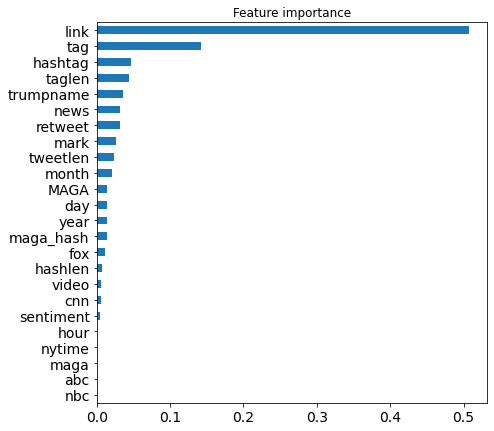

In [ ]:
pd.Series(modelxgb.feature_importances_,index = X.columns).sort_values(ascending=True).plot(kind='barh',title='Feature importance',figsize = (7,7),fontsize = 14)
plt.show()

Choosing top 10 features for training and testing

In [ ]:
cols = pd.Series(modelxgb.feature_importances_,index = X.columns).sort_values(ascending=True).nlargest(10).index.tolist()# make predictions for test data and evaluate
cols

['link',
 'tag',
 'hashtag',
 'taglen',
 'trumpname',
 'news',
 'retweet',
 'mark',
 'tweetlen',
 'month']

In [ ]:
X = X[cols]
X.head()

,link,tag,hashtag,taglen,trumpname,news,retweet,mark,tweetlen,month
0,0,0,0,0,0,0,0,1,142,3
1,0,0,0,0,0,0,0,0,116,3
2,0,0,0,0,0,0,0,1,138,2
3,0,1,0,1,0,1,0,1,137,2
4,0,0,0,0,0,0,0,1,137,2


# Split data into train-test with 80-20 split and try different models

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.2,random_state=42)


# RandomForest

## Classify with random forest model

In [ ]:
modelrf = RandomForestClassifier(random_state=42)
y_pred = modelrf.fit(X_train, y_train).predict(X_test)
acc_rf = metrics.accuracy_score(y_test, y_pred)
print("Acc: %.2f%%" % (acc_rf * 100.0))

Acc: 86.45%


## Classify with gradient boosting model

In [ ]:
modelxgb = XGBClassifier()
modelxgb.fit(X_train.values, y_train)
# make predictions for test data and evaluate
predictions = modelxgb.predict(X_test.values)
acc_xgb = metrics.accuracy_score(y_test, predictions)
print("Acc: %.2f%%" % (acc_xgb * 100.0))

Acc: 86.79%


# Classify with voting classifier

In [ ]:
clf1 = DecisionTreeClassifier(max_depth=12,random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='rbf', probability=True,random_state=42)
clf4 = GaussianNB()
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3),('nb',clf4)], voting='soft', weights=[2,1,1,2])
eclf.fit(X_train.values, y_train)
predictions = eclf.predict(X_test.values)
acc_eclf = metrics.accuracy_score(y_test, predictions)
print("Acc: %.2f%%" % (acc_eclf * 100.0))

Acc: 85.12%


# Classifying using Transformer-based model, BERT-base-uncased - on tweets text only

In [ ]:
!pip install --quiet transformers

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 36.2 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 


In [ ]:
!pip install --quiet simpletransformers

     |████████████████████████████████| 249 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 43.4 MB/s 
     |████████████████████████████████| 10.1 MB 26.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 346 kB 54.3 MB/s 
     |████████████████████████████████| 1.8 MB 37.2 MB/s 
     |████████████████████████████████| 145 kB 42.9 MB/s 
     |████████████████████████████████| 181 kB 43.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 56.4 MB/s 
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
     |████████████████████████████████| 140 kB 48.1 MB/s 
     |████████████████████████████████| 127 kB 65.2 MB/s 
     |████████████████████████████████| 144 kB 37.9 MB/s 
     |████████████████████████████████| 271 kB 37.7 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
# Create a ClassificationModel
np.random.seed(0)
model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels=2,
    args={"reprocess_input_data": True,
          "overwrite_output_dir": True,
          'use_multiprocessing':False,
         'use_multiprocessing_for_evaluation':False,
         'manual_seed': 12,
         "max_seq_length" : 512,
          "num_train_epochs" : 5},
)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def bert_classifier(model,train,test,clean_text = False):
  if clean_text:
      train['text'] = train['text'].apply(lambda x: clean_tweets(x))
      test['text'] = test['text'].apply(lambda x: clean_tweets(x))
  # Train the model
  model.train_model(train)
  # Evaluate the model
  predictions, _ = model.predict(test.text.tolist())
  acc_brt=metrics.accuracy_score(test.labels, predictions)
  # result, model_outputs, wrong_predictions = model.eval_model(test)
  print("Accuracy : %.2f%%" % (acc_brt * 100.0))
  return acc_brt

In [ ]:
data_forbert =  df[['tweet','label']]
data_forbert.columns = ['text','labels']
train, validation = train_test_split(data_forbert, test_size=0.2)

Check accuracy on tweets text, without any preprocessing:

In [ ]:
val_acc_raw = bert_classifier(model,train, validation,clean_text = False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Accuracy : 89.30%


Check accuracy on tweets text, after applying simple pre-processing such as removing special characters and RT statements:

In [ ]:
val_acc_clean = bert_classifier(model,train, validation,clean_text = True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Accuracy : 88.13%


# Plotting calculated accuracy over all inspected models

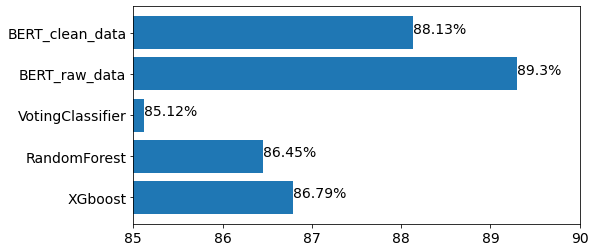

In [ ]:
D = {'XGboost':np.round(acc_xgb*100,2),
     'RandomForest': np.round(acc_rf*100,2),
     'VotingClassifier': np.round(acc_eclf*100,2),
     'BERT_raw_data':np.round(val_acc_raw*100,2),
     'BERT_clean_data':np.round(val_acc_clean*100,2)}
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(*zip(*D.items()),)
for index,data in enumerate(D.values()):
    ax.text(x=data , y =index , s=f"{data}%" , fontdict=dict(fontsize=14))
plt.xlim(85, 90)
plt.show()

# Test set labels predictions

In [ ]:
test = pd.read_csv('test_data.tsv' ,sep='\t|\n',names=['id', 'user', 'text', 'date'], engine='python')

In [ ]:
data_forbert =  df[['tweet','label']]
data_forbert.columns = ['text','labels']

In [ ]:
model.train_model(data_forbert)
# Evaluate the model
predictions, _ = model.predict(test.text.tolist())

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/374 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/374 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/374 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
test['labels'] = predictions
test['labels'] = test['labels'].apply(lambda x: 'android' if x == 1 else 'iphone')

In [ ]:
test.to_csv('203909320_346243579_submission.tsv', sep='\t', index=False,header=False)